<a href="https://colab.research.google.com/github/magbotta/sepsis-mimiciii/blob/main/INMR96_Digital_Health_and_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction

# Load Libraries 

Load libraries and authenticate

**Packages for data handling**

In [1]:
import pandas as pd
import numpy as np

**Packages visualization**

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

**Packages for data analysis and modelling**

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# New section

# Data Preparation: Gathering Data

Gather all relevant information for each hospital stay across several tables in MIMIC-III. 

| Table | Variables to be extracted |
| --- | --- | 
| `admissions` | The basis of the table. <br>`SUBJECT_ID`, `HADM_ID`, `ADMISSION_TYPE`, <br>`ADMITTIME`, `DISCHTIME`, `DEATHTIME`, `HOSPITAL_EXPIRE_FLAG`, <br>`DIAGNOSIS`, `MARITAL_STATUS`,`INSURANCE`, `LANGUAGE`, `RELIGION`, `ETHNICITY` |
| `patients` | `GENDER`, `DOB` | 
| `icustays` | `LOS` |
| `labevents` | Number of events relating to laboratory tests | 
| `callouts` | Number of callouts of the patients |
| `prescriptions` | Number of prescriptions ordered | 
| `procedures_icd` | Number of procedures received | 
| `inputevents_cv`<br>`inputevents_mv` | Number of fluid input records |
| `outputevents` | Number of fluid output records |
| `diagnosis` | Number of diagnoses | 
| `transfers` | Number of transfers within hospital stay |
| `cptevents` | Number of events recorded in Current Procedural Terminology |
| `microbiologyevents` | Number of microbiology events or tests |

The SQL query for retrieving all these information is shown below, and can be broken down into two key steps:

* Calculate the event counts from each table listed above, except `admissions`, `patients` and `icustays`. Create alias for each of them using keywords `WITH` and `AS`.
* Link all the tables to the `admissions` table using `LEFT JOIN`, with `HADM_ID` or `SUBJECT_ID` as the common column. 

Note that you also can run it from your Bigquery console.

In [5]:
%%bigquery --project physionet-data-303120 df
# make sure you change the project ID above!

WITH 
icustay AS (SELECT HADM_ID, SUM(LOS) AS LOS_ICU FROM `physionet-data.mimiciii_clinical.icustays` GROUP BY HADM_ID), 
callout AS (SELECT HADM_ID, COUNT(HADM_ID) AS CALLOUT_COUNT FROM  `physionet-data.mimiciii_clinical.callout` GROUP BY HADM_ID),
diags AS (SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT FROM `physionet-data.mimiciii_clinical.diagnoses_icd` GROUP BY HADM_ID),
preps AS (SELECT HADM_ID, COUNT(HADM_ID) AS PRES_COUNT FROM `physionet-data.mimiciii_clinical.prescriptions` GROUP BY HADM_ID),
procs AS (SELECT HADM_ID, COUNT(HADM_ID) AS PROC_COUNT FROM `physionet-data.mimiciii_clinical.procedures_icd` GROUP BY HADM_ID),
cpts AS (SELECT HADM_ID, COUNT(HADM_ID) AS CPT_COUNT FROM `physionet-data.mimiciii_clinical.cptevents` GROUP BY HADM_ID),
labs AS (SELECT HADM_ID, COUNT(HADM_ID) AS LAB_COUNT FROM `physionet-data.mimiciii_clinical.labevents` GROUP BY HADM_ID),
inputs_cv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_CV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_cv` GROUP BY HADM_ID),
inputs_mv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_MV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_mv` GROUP BY HADM_ID),
outputs AS (SELECT HADM_ID, COUNT(HADM_ID) AS OUTPUT_COUNT FROM `physionet-data.mimiciii_clinical.outputevents` GROUP BY HADM_ID),
transfers AS (SELECT HADM_ID, COUNT(HADM_ID) AS TRANSFER_COUNT FROM `physionet-data.mimiciii_clinical.transfers` GROUP BY HADM_ID),
micros AS (SELECT HADM_ID, COUNT(HADM_ID) AS MICRO_COUNT FROM `physionet-data.mimiciii_clinical.microbiologyevents` GROUP BY HADM_ID),
diafeature AS (WITH co_dx AS
(
	SELECT subject_id, hadm_id
  , MAX(
    	CASE
        -- septicemia
    		WHEN substring(icd9_code,1,3) = '038' THEN 1
        -- septicemic, bacteremia, disseminated fungal infection, disseminated candida infection
				-- NOTE: the paper specifies 020.0 ... but this is bubonic plague
				-- presumably, they meant 020.2, which is septicemic plague
        WHEN substring(icd9_code,1,4) in ('0202','7907','1179','1125') THEN 1
        -- disseminated fungal endocarditis
        WHEN substring(icd9_code,1,5) = '11281' THEN 1
      ELSE 0 END
    ) AS sepsis
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('7991') THEN 1
        WHEN substring(icd9_code,1,5) in ('51881','51882','51885','78609') THEN 1
      ELSE 0 END
    ) AS respiratory
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('4580','7855','4580','4588','4589','7963') THEN 1
        WHEN substring(icd9_code,1,5) in ('785.51','785.59') THEN 1
      ELSE 0 END
    ) AS cardiovascular
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('584','580','585') THEN 1
      ELSE 0 END
    ) AS renal
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('570') THEN 1
        WHEN substring(icd9_code,1,4) in ('5722','5733') THEN 1
      ELSE 0 END
    ) AS hepatic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2862','2866','2869','2873','2874','2875') THEN 1
      ELSE 0 END
    ) AS hematologic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2762') THEN 1
      ELSE 0 END
    ) AS metabolic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('293') THEN 1
        WHEN substring(icd9_code,1,4) in ('3481','3483') THEN 1
        WHEN substring(icd9_code,1,5) in ('78001','78009') THEN 1
      ELSE 0 END
    ) AS neurologic
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  GROUP BY subject_id, hadm_id
)
-- procedure codes:
-- "96.7 - Ventilator management"
-- translated:
--    9670	Continuous invasive mechanical ventilation of unspecified duration
--    9671	Continuous invasive mechanical ventilation for less than 96 consecutive hours
--    9672	Continuous invasive mechanical ventilation for 96 consecutive hours or more
-- "39.95 - Hemodialysis"
--    3995	Hemodialysis
-- "89.14 - Electroencephalography"
--    8914	Electroencephalogram
, co_proc as
(
  SELECT subject_id, hadm_id
  , MAX(CASE WHEN substring(icd9_code,1,3) = '967' then 1 ELSE 0 END) as respiratory
  , MAX(CASE WHEN substring(icd9_code,1,4) = '3995' then 1 ELSE 0 END) as renal
  , MAX(CASE WHEN substring(icd9_code,1,4) = '8914' then 1 ELSE 0 END) as neurologic
  FROM  `physionet-data.mimiciii_clinical.procedures_icd`
  GROUP BY subject_id, hadm_id
)
select adm.subject_id, adm.hadm_id
, co_dx.sepsis
, CASE
    WHEN co_dx.respiratory = 1 OR co_proc.respiratory = 1
      OR co_dx.cardiovascular = 1
      OR co_dx.renal = 1 OR co_proc.renal = 1
      OR co_dx.hepatic = 1
      OR co_dx.hematologic = 1
      OR co_dx.metabolic = 1
      OR co_dx.neurologic = 1 OR co_proc.neurologic = 1
    THEN 1
  ELSE 0 END as organ_failure
, case when co_dx.respiratory = 1 or co_proc.respiratory = 1 then 1 else 0 end as respiratory
, co_dx.cardiovascular
, case when co_dx.renal = 1 or co_proc.renal = 1 then 1 else 0 end as renal
, co_dx.hepatic
, co_dx.hematologic
, co_dx.metabolic
, case when co_dx.neurologic = 1 or co_proc.neurologic = 1 then 1 else 0 end as neurologic
FROM `physionet-data.mimiciii_clinical.admissions` adm
left join co_dx
  on adm.hadm_id = co_dx.hadm_id
left join co_proc
  on adm.hadm_id = co_proc.hadm_id),
vitals as (
SELECT pvt.subject_id, pvt.hadm_id, pvt.icustay_id
-- Easier names
, min(case when VitalID = 1 then valuenum else null end) as HeartRate_Min
, max(case when VitalID = 1 then valuenum else null end) as HeartRate_Max
, avg(case when VitalID = 1 then valuenum else null end) as HeartRate_Mean
, min(case when VitalID = 2 then valuenum else null end) as SysBP_Min
, max(case when VitalID = 2 then valuenum else null end) as SysBP_Max
, avg(case when VitalID = 2 then valuenum else null end) as SysBP_Mean
, min(case when VitalID = 3 then valuenum else null end) as DiasBP_Min
, max(case when VitalID = 3 then valuenum else null end) as DiasBP_Max
, avg(case when VitalID = 3 then valuenum else null end) as DiasBP_Mean
, min(case when VitalID = 4 then valuenum else null end) as MeanBP_Min
, max(case when VitalID = 4 then valuenum else null end) as MeanBP_Max
, avg(case when VitalID = 4 then valuenum else null end) as MeanBP_Mean
, min(case when VitalID = 5 then valuenum else null end) as RespRate_Min
, max(case when VitalID = 5 then valuenum else null end) as RespRate_Max
, avg(case when VitalID = 5 then valuenum else null end) as RespRate_Mean
, min(case when VitalID = 6 then valuenum else null end) as TempC_Min
, max(case when VitalID = 6 then valuenum else null end) as TempC_Max
, avg(case when VitalID = 6 then valuenum else null end) as TempC_Mean
, min(case when VitalID = 7 then valuenum else null end) as SpO2_Min
, max(case when VitalID = 7 then valuenum else null end) as SpO2_Max
, avg(case when VitalID = 7 then valuenum else null end) as SpO2_Mean
, min(case when VitalID = 8 then valuenum else null end) as Glucose_Min
, max(case when VitalID = 8 then valuenum else null end) as Glucose_Max
, avg(case when VitalID = 8 then valuenum else null end) as Glucose_Mean

FROM  (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

  from `physionet-data.mimiciii_clinical.icustays`  ie
  left join  `physionet-data.mimiciii_clinical.chartevents` ce
  on ie.subject_id = ce.subject_id and ie.hadm_id = ce.hadm_id and ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and DATE_ADD(ie.intime , INTERVAL 1 day)
  -- exclude rows marked as error
  and ce.error IS DISTINCT FROM 1
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
) pvt
group by pvt.subject_id, pvt.hadm_id, pvt.icustay_id
order by pvt.subject_id, pvt.hadm_id, pvt.icustay_id)  


SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE, 
adm.ADMITTIME, adm.DISCHTIME, adm.DEATHTIME, adm.HOSPITAL_EXPIRE_FLAG, 
adm.DIAGNOSIS, adm.ETHNICITY,
pts.GENDER, pts.DOB, 
icustay.LOS_ICU, diags.DIAG_COUNT, cpts.CPT_COUNT, transfers.TRANSFER_COUNT, micros.MICRO_COUNT, diafeature.SEPSIS , diafeature.ORGAN_FAILURE, diafeature.CARDIOVASCULAR, diafeature.RENAL, diafeature.HEPATIC,
diafeature.HEMATOLOGIC, diafeature.METABOLIC, diafeature.NEUROLOGIC ,vitals.HeartRate_Mean, vitals.SysBP_Mean, vitals.DiasBP_Mean, vitals.MeanBP_Mean, vitals.RespRate_Mean, vitals.TempC_Mean, vitals.SpO2_Mean, vitals.Glucose_Mean
FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN `physionet-data.mimiciii_clinical.patients` AS pts on adm.SUBJECT_ID = pts.SUBJECT_ID
LEFT JOIN icustay on adm.HADM_ID = icustay.HADM_ID
LEFT JOIN callout on adm.HADM_ID = callout.HADM_ID
LEFT JOIN diags on adm.HADM_ID = diags.HADM_ID
LEFT JOIN preps on adm.HADM_ID = preps.HADM_ID
LEFT JOIN procs on adm.HADM_ID = procs.HADM_ID
LEFT JOIN cpts on adm.HADM_ID = cpts.HADM_ID
LEFT JOIN labs on adm.HADM_ID = labs.HADM_ID
LEFT JOIN inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
LEFT JOIN inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
LEFT JOIN outputs on adm.HADM_ID = outputs.HADM_ID
LEFT JOIN transfers on adm.HADM_ID = transfers.HADM_ID
LEFT JOIN micros on adm.HADM_ID = micros.HADM_ID
LEFT JOIN diafeature on adm.HADM_ID = diafeature.HADM_ID
LEFT JOIN vitals on adm.HADM_ID = vitals.HADM_ID



review the gathered dataset.

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,9,NaN,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27,3.2458,9,NaN,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,WHITE,M,1810-07-29,1.7603,15,8.0,4,NaN,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000


In [7]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'ETHNICITY', 'GENDER',
       'DOB', 'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL',
       'HEPATIC', 'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean'],
      dtype='object')

Get General Info from the dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   ETHNICITY             62477 non-null  object        
 9   GENDER                62477 non-null  object        
 10  DOB                   62477 non-null  datetime64[ns]
 11  LOS_ICU               61277 non-null  float64       
 12  DIAG_COUNT            62477 non-null  int64         
 13  CPT_COUNT       

Check for Missing Values

In [9]:
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               55853
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
DIAG_COUNT                  0
CPT_COUNT               15047
TRANSFER_COUNT              0
MICRO_COUNT             10334
SEPSIS                      0
ORGAN_FAILURE               0
CARDIOVASCULAR              0
RENAL                       0
HEPATIC                     0
HEMATOLOGIC                 0
METABOLIC                   0
NEUROLOGIC                  0
HeartRate_Mean           3429
SysBP_Mean              10223
DiasBP_Mean             10225
MeanBP_Mean             10189
RespRate_Mean           10248
TempC_Mean              11095
SpO2_Mean               10244
Glucose_Mean             9486
dtype: int64

# Data Preparation: Pre-processing Data




Now, we want to pre-process the data such that it is ready to be fed into a model. We also want to make variables that are useful for the model to learn from, a.k.a. feature engineering. There are 5 types of feature engineering:

* **Creating**. Create new features from existing ones if they provide additional value when predicting our outcome (e.g. creating age from date of birth and admission). 
* **Converting**. The raw dataset is most probably not ready for direct modelling. Some features need to be converted or normalized to meet the model input requirements. Usually, before we feed the training dataset into models, all datatypes need to be converted to numerical values for mathematical computation.
* **Completing**. Most models require no missing values in input variables in order to work. Model algorithms work best when there are no missing values. If missing values exist in the dataset, we may need to handle them either by (i) filling in any missing values through estimation; (ii) excluding the variable as an input; (iii) excluding the learning samples with any missing value present. 
* **Correcting**. We may also come across errors or inaccurate values within a dataset. Try to correct these values or exclude the samples with errors. One way to do this is to look out for any outliers among features.
* **Correlating**. Having redundant information within the input variable set would not help the model training process and could even lead to worse performances. Thus, one thing we can do is to perform basic statistical analysis. Which features within the dataset contribute significantly to our target variable? This can be tested both for numerical and categorical features in the given dataset.

## Creating
1. As `HOSPITAL_EXPIRE_FLAG` indicates in-hospital death (see [MIMIC's documentation](https://mimic.physionet.org/about/mimic/)), it will be our **prediction target**.<br>Let's rename the variable `HOSPITAL_EXPIRE_FLAG` into a more description one, `IN_HOSP_DEATH`. Also note that it is already numeric (either 1 or 0) and has no missing values, thus can be used as for model training.  

In [10]:
df = df.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'IN_HOSP_DEATH'})

In [11]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean'],
      dtype='object')

In [12]:
df['IN_HOSP_DEATH'].isna().sum() # 

0

In [13]:
df['IN_HOSP_DEATH'].value_counts()

0    55853
1     6624
Name: IN_HOSP_DEATH, dtype: int64

2. We don't have a column indicating age, but can we calculate it based on 'DOB'(Date of birth) and 'ADMITTIME'.

In [14]:
df['AGE'] = df['ADMITTIME'].sub(df['DOB']) // np.timedelta64(1,'Y') # subtract DOB from ADMITTIME and express difference in years 'Y'

df['AGE']

0         60
1         18
2         70
3       -285
4         76
        ... 
62472     38
62473     48
62474     33
62475     54
62476     41
Name: AGE, Length: 62477, dtype: int64

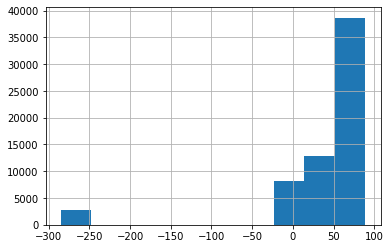

In [15]:
df['AGE'].hist()

3. Likewise, we can create a variable indicating hospital length of stay.

In [16]:
df['LOS'] = df['DISCHTIME'].sub(df['ADMITTIME']) / np.timedelta64(1,'D') # subtract ADMITTIME from DISCHTIME and express difference in days 'D'

df['LOS']

0         4.164583
1        11.112500
2        13.895833
3         5.634722
4         5.585417
           ...    
62472     1.872917
62473     2.502083
62474     1.609722
62475     3.710417
62476     3.100000
Name: LOS, Length: 62477, dtype: float64

In [17]:
df['LOS'].describe()

count    62477.000000
mean        11.166875
std         14.141929
min         -0.945139
25%          3.866667
50%          6.888194
75%         12.938889
max        294.660417
Name: LOS, dtype: float64

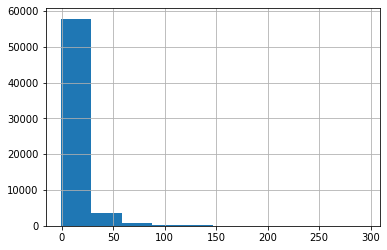

In [18]:
df['LOS'].hist()

Create Adult Variable >= 18

In [19]:
df.loc[df['AGE'] >= 18, 'ADULT'] = 1

4.  We will also use **SEPSIS** as Our **Prediction Target** 

Check for Missing (NA)

In [20]:
df['SEPSIS'].isna().sum() # 

0

Also note that SEPSIS Variable is already numeric (either 1 or 0) and has no missing values, thus can be used as for model training.

## Converting

The length of stay varies across patients, we may normalize the total count values into daily average count values in order to retrieve the frequency of the events. Here, we compute the values and save them as new columns, and append '_DAY' to the original column names.

In [21]:
for col_name in ['DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name + '_DAY'] = df[col_name] / np.maximum(np.ceil(df['LOS']), 1)

In [22]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,1.0,3.000000,1.400000,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,9,NaN,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.750000,NaN,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27,3.2458,9,NaN,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.642857,NaN,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,WHITE,M,1810-07-29,1.7603,15,8.0,4,NaN,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000,-285,5.634722,NaN,2.500000,1.333333,0.666667,NaN
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,3.666667,1.666667,1.166667,0.833333


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          62477 non-null  int64         
 1   HADM_ID             62477 non-null  int64         
 2   ADMISSION_TYPE      62477 non-null  object        
 3   ADMITTIME           62477 non-null  datetime64[ns]
 4   DISCHTIME           62477 non-null  datetime64[ns]
 5   DEATHTIME           6624 non-null   object        
 6   IN_HOSP_DEATH       62477 non-null  int64         
 7   DIAGNOSIS           62452 non-null  object        
 8   ETHNICITY           62477 non-null  object        
 9   GENDER              62477 non-null  object        
 10  DOB                 62477 non-null  datetime64[ns]
 11  LOS_ICU             61277 non-null  float64       
 12  DIAG_COUNT          62477 non-null  int64         
 13  CPT_COUNT           47430 non-null  float64   

## Completing

#### Numerical features

Regarding the features related to counts and counts per day, we can simply fill all NaN values with 0.

In [24]:
for col_name in ['DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name] = df[col_name].fillna(0)
  df[col_name + '_DAY'] = df[col_name + '_DAY'].fillna(0)

In [25]:
df['DIAG_COUNT'] = df['DIAG_COUNT'].fillna(0)
df['LOS_ICU'] = df['LOS_ICU'].fillna(0)

In [26]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,1.0,3.000000,1.400000,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,9,0.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.750000,0.000000,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27,3.2458,9,0.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.642857,0.000000,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,WHITE,M,1810-07-29,1.7603,15,8.0,4,0.0,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000,-285,5.634722,NaN,2.500000,1.333333,0.666667,0.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,3.666667,1.666667,1.166667,0.833333


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          62477 non-null  int64         
 1   HADM_ID             62477 non-null  int64         
 2   ADMISSION_TYPE      62477 non-null  object        
 3   ADMITTIME           62477 non-null  datetime64[ns]
 4   DISCHTIME           62477 non-null  datetime64[ns]
 5   DEATHTIME           6624 non-null   object        
 6   IN_HOSP_DEATH       62477 non-null  int64         
 7   DIAGNOSIS           62452 non-null  object        
 8   ETHNICITY           62477 non-null  object        
 9   GENDER              62477 non-null  object        
 10  DOB                 62477 non-null  datetime64[ns]
 11  LOS_ICU             62477 non-null  float64       
 12  DIAG_COUNT          62477 non-null  int64         
 13  CPT_COUNT           62477 non-null  float64   

In [28]:
df['HeartRate_Mean'] = df['HeartRate_Mean'].fillna(0)
df['SysBP_Mean'] = df['SysBP_Mean'].fillna(0)
df['DiasBP_Mean'] = df['DiasBP_Mean'].fillna(0)
df['MeanBP_Mean'] = df['MeanBP_Mean'].fillna(0)
df['RespRate_Mean'] = df['RespRate_Mean'].fillna(0)
df['TempC_Mean'] = df['TempC_Mean'].fillna(0)
df['SpO2_Mean'] = df['SpO2_Mean'].fillna(0)
df['Glucose_Mean'] = df['Glucose_Mean'].fillna(0)

#### Categorical features

There are three categorical variables containing missing values.

`MARITAL_STATUS`: fill in the default value

In [29]:
df.info

<bound method DataFrame.info of        SUBJECT_ID  HADM_ID  ... TRANSFER_COUNT_DAY MICRO_COUNT_DAY
0            7275   136809  ...           0.600000        9.400000
1           17575   187131  ...           0.250000        2.250000
2           25251   142346  ...           0.428571        3.285714
3           32339   181355  ...           0.666667        0.000000
4           30746   155603  ...           1.166667        0.833333
...           ...      ...  ...                ...             ...
62472       31355   146717  ...           1.500000        1.000000
62473       58016   105567  ...           1.000000        3.000000
62474       64255   145415  ...           1.000000        0.500000
62475       83060   122843  ...           1.000000        0.250000
62476       84694   149446  ...           1.000000        4.500000

[62477 rows x 39 columns]>

## Correcting

As we have seen previously, the age column contains certain suspicious values. Why is that?

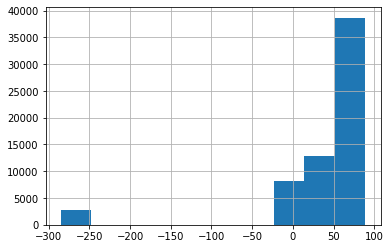

In [30]:
df['AGE'].hist()

In [31]:
df.loc[df['AGE'] < 0, 'AGE'] = 90

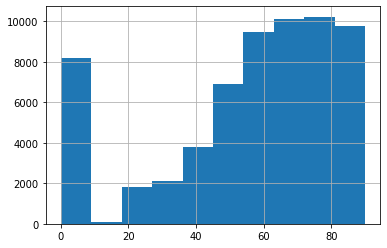

In [32]:
df['AGE'].hist()

A number of measures were performed to protect patient privacy. Quoting from [MIMIC-III's documentation](https://mimic.physionet.org/mimicdata/time/), 

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

> Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

In other words, all patients with a negative 'age' calculated above are older than 89. For illustration, let's simply set them to be 90.

In [33]:
df.loc[df['AGE'] < 0, 'AGE'] = 90

## Encoding for Categorical Variables (Converting)

ADMISSION_TYPE

In [34]:
tmp_df_admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION_TYPE')
tmp_df_admissions

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
62472,0,1,0,0
62473,0,1,0,0
62474,0,1,0,0
62475,0,1,0,0


In [35]:
df = pd.concat([df, tmp_df_admissions], axis = 1) 
# add the above temporary dataframe to the original dataframe, axis = 1 specifies that we want to stack them horizontally not vertically

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SUBJECT_ID                62477 non-null  int64         
 1   HADM_ID                   62477 non-null  int64         
 2   ADMISSION_TYPE            62477 non-null  object        
 3   ADMITTIME                 62477 non-null  datetime64[ns]
 4   DISCHTIME                 62477 non-null  datetime64[ns]
 5   DEATHTIME                 6624 non-null   object        
 6   IN_HOSP_DEATH             62477 non-null  int64         
 7   DIAGNOSIS                 62452 non-null  object        
 8   ETHNICITY                 62477 non-null  object        
 9   GENDER                    62477 non-null  object        
 10  DOB                       62477 non-null  datetime64[ns]
 11  LOS_ICU                   62477 non-null  float64       
 12  DIAG_COUNT        

`GENDER`

As the column only takes on two values 'M' and 'F', it is easier to simply do a logical operation and save the results as a new column. 

In [37]:
df['GENDER'].value_counts()

M    34986
F    27491
Name: GENDER, dtype: int64

In [38]:
df['GENDER_F'] = (df['GENDER'] == 'F') * 1

In [39]:
df['GENDER_F'].value_counts()

0    34986
1    27491
Name: GENDER_F, dtype: int64

In [40]:
tmp_categories = list(df['ETHNICITY'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['ETHNICITY'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'ETHNICITY') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,1,0,0,0
62475,0,0,1,0


In [41]:
dfall = df

In [42]:
df = df[df.AGE >= 18]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54208 entries, 0 to 62476
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        54208 non-null  int64         
 1   HADM_ID                           54208 non-null  int64         
 2   ADMISSION_TYPE                    54208 non-null  object        
 3   ADMITTIME                         54208 non-null  datetime64[ns]
 4   DISCHTIME                         54208 non-null  datetime64[ns]
 5   DEATHTIME                         6549 non-null   object        
 6   IN_HOSP_DEATH                     54208 non-null  int64         
 7   DIAGNOSIS                         54183 non-null  object        
 8   ETHNICITY                         54208 non-null  object        
 9   GENDER                            54208 non-null  object        
 10  DOB                               54208 non-nu

# Cohort Selection

Filter 18 years and Above

In [44]:
df = df[df.ADULT == 1]

In [45]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,1.0,3.000000,1.400000,0.600000,9.400000,0,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,9,0.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.750000,0.000000,0.250000,2.250000,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27,3.2458,9,0.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.642857,0.000000,0.428571,3.285714,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,3.666667,1.666667,1.166667,0.833333,0,1,0,0,0,1,0,0,0
6,51820,148131,EMERGENCY,2184-02-06 17:37:00,2184-02-08 15:23:00,NaT,0,UPPER GI BLEED,WHITE,F,2095-03-01,1.9061,7,5.0,3,4.0,0,0,0,0,0,0,0,0,64.884615,109.320000,58.480000,72.280000,18.466667,36.611111,97.769231,109.000000,88,1.906944,1.0,3.500000,2.500000,1.500000,2.000000,0,1,0,0,1,1,0,0,0


# Save your pre-processed dataframe 

When you are done with data preparation, it is highly recommended for you to save your resulting dataframe so that you do not need to go through all the preprocessing steps whenever you come back to work on it (or you lose internet connection). We can save and load datasets to/from your Google Drive.

First let's check the pre-processed dataframe. Yours may look differently if you altered the pre-processing steps.

In [46]:
# Grant access to your Google Drive. You would need to authenicate once again
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [47]:
df.to_csv(gdrive_rootpath + 'mimic_sepsis_clean.csv', index = False)

In [48]:
pd.read_csv(gdrive_rootpath + 'mimic_sepsis_clean.csv')

# if you want to save it as a variable, run this instead
# df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11 00:00:00,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,1.0,3.000000,1.400000,0.600000,9.400000,0,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,9,0.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.750000,0.000000,0.250000,2.250000,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27 00:00:00,3.2458,9,0.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.642857,0.000000,0.428571,3.285714,0,1,0,0,0,1,0,0,0
3,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16 00:00:00,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,3.666667,1.666667,1.166667,0.833333,0,1,0,0,0,1,0,0,0
4,51820,148131,EMERGENCY,2184-02-06 17:37:00,2184-02-08 15:23:00,NaN,0,UPPER GI BLEED,WHITE,F,2095-03-01 00:00:00,1.9061,7,5.0,3,4.0,0,0,0,0,0,0,0,0,64.884615,109.320000,58.480000,72.280000,18.466667,36.611111,97.769231,109.000000,88,1.906944,1.0,3.500000,2.500000,1.500000,2.000000,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51457,31355,146717,EMERGENCY,2110-07-28 22:03:00,2110-07-30 19:00:00,NaN,0,NECROTIZING PANCREATITIS,UNKNOWN/NOT SPECIFIED,M,2071-09-27 00:00:00,0.8021,2,1.0,3,2.0,0,0,0,0,0,0,0,0,116.588235,142.631579,72.157895,87.058824,19.473684,38.083334,96.647059,152.000000,38,1.872917,1.0,1.000000,0.500000,1.500000,1.000000,0,1,0,0,0,0,0,1,0
51458,58016,105567,EMERGENCY,2118-10-08 20:59:00,2118-10-11 09:02:00,NaN,0,GALLSTONES,UNABLE TO OBTAIN,M,2070-06-16 00:00:00,2.0868,10,6.0,3,9.0,0,1,1,1,0,1,0,0,90.750000,86.521739,58.826087,65.826087,15.458333,36.259259,99.125000,67.333333,48,2.502083,1.0,3.333333,2.000000,1.000000,3.000000,0,1,0,0,0,0,0,0,1
51459,64255,145415,EMERGENCY,2151-11-05 22:32:00,2151-11-07 13:10:00,NaN,0,STATUS EPILEPTICUS,WHITE,F,2118-09-12 00:00:00,1.6445,1,4.0,2,1.0,0,0,0,0,0,0,0,0,102.041667,112.041667,64.166667,74.750000,16.607143,37.355556,99.210526,90.000000,33,1.609722,1.0,0.500000,2.000000,1.000000,0.500000,0,1,0,0,1,1,0,0,0
51460,83060,122843,EMERGENCY,2158-10-11 19:08:00,2158-10-15 12:11:00,NaN,0,RIGHTBRONCHUS MASS,UNKNOWN/NOT SPECIFIED,M,2103-12-06 00:00:00,0.9236,13,9.0,4,1.0,0,0,0,0,0,0,0,0,77.600000,117.666667,58.266667,71.666667,18.750000,36.266667,92.600000,197.200000,54,3.710417,1.0,3.250000,2.250000,1.000000,0.250000,0,1,0,0,0,0,0,1,0


# Exploratory data analysis

In [169]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS', 'ADULT',
       'DIAG_COUNT_DAY', 'CPT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS'],
      dtype='object')

## Prediction Target: `SEPSIS`

In [170]:
df['SEPSIS'].value_counts()

0    45255
1     8953
Name: SEPSIS, dtype: int64

## Prediction Target: `IN_HOSP_DEATH`

In [171]:
df['IN_HOSP_DEATH'].value_counts()

0    47659
1     6549
Name: IN_HOSP_DEATH, dtype: int64

The overall in-hospital death rate is 5854 / (53122 + 5854) = 9.93% 

## Categorical features

We can calculate and visualize each feature by group. You may also apply statistical tests to see if there are significant differences between groups.

For simple visualizations in Python, the package [seaborn](https://seaborn.pydata.org/) may come in handy.

In [172]:
# visualization package
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

`GENDER`

The average in-hospital mortality rate for each gender

In [173]:
df[['GENDER', 'IN_HOSP_DEATH']].groupby(['GENDER']).mean()

,IN_HOSP_DEATH
GENDER,
F,0.125596
M,0.117100


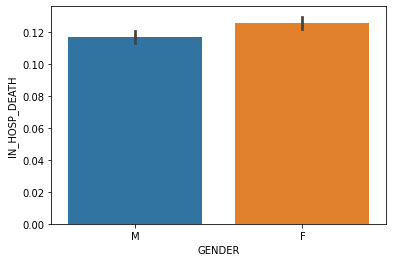

In [174]:
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', data = df)

`ADMISSION_TYPE`

In [175]:
df[['ADMISSION_TYPE', 'IN_HOSP_DEATH']].groupby(['ADMISSION_TYPE']).mean()

,IN_HOSP_DEATH
ADMISSION_TYPE,
ELECTIVE,0.031440
EMERGENCY,0.136695
URGENT,0.129170


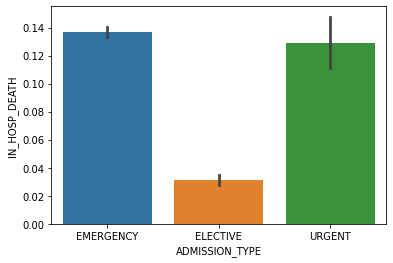

In [176]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'IN_HOSP_DEATH', data = df)

## Numerical features

In [177]:
df.describe()

,SUBJECT_ID,HADM_ID,IN_HOSP_DEATH,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
count,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,51462.0,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.0,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000,54208.000000
mean,36617.271786,149985.074731,0.120812,4.860773,12.234320,12.811559,4.704675,13.863470,0.165160,0.596794,0.138153,0.318532,0.037356,0.104911,0.091979,0.080412,82.299417,114.375117,58.336950,74.999598,18.130181,34.827908,93.411634,134.412104,63.562094,11.112964,1.0,1.892853,1.076678,0.695213,1.133151,0.149037,0.824970,0.0,0.025992,0.436965,0.711094,0.089009,0.079324,0.120573
std,28986.643624,28928.097561,0.325912,7.570722,6.715598,20.628739,2.220978,25.897515,0.371328,0.490546,0.345064,0.465911,0.189635,0.306441,0.288999,0.271933,22.320960,28.277533,15.868869,18.518615,5.369300,8.345167,18.827445,615.783726,17.111109,13.053650,0.0,2.011830,0.851507,0.542040,2.111380,0.356128,0.379996,0.0,0.159114,0.496015,0.453258,0.284759,0.270246,0.325633
min,3.000000,100001.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,-0.945139,1.0,0.038462,0.000000,0.019231,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13183.000000,124888.500000,0.000000,1.233100,8.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.035406,105.390700,52.272727,69.291667,15.760000,36.355556,95.923077,107.500000,52.000000,4.148611,1.0,0.777778,0.400000,0.352941,0.200000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26523.000000,150047.000000,0.000000,2.312950,10.000000,7.000000,4.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.692308,115.636364,59.096774,76.032926,18.000000,36.750732,97.428571,127.200000,65.000000,7.221875,1.0,1.333333,1.000000,0.571429,0.625000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,59875.000000,175048.500000,0.000000,4.999500,16.000000,14.000000,6.000000,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,95.035714,128.681818,66.676112,84.105263,20.880000,37.158730,98.650000,153.500000,77.000000,13.118056,1.0,2.250000,1.500000,0.846154,1.444444,0.000000,1.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,99999.000000,199999.000000,1.000000,260.708900,39.000000,362.000000,25.000000,565.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,163.875000,215.833333,132.333333,153.838710,47.000000,40.833333,100.000000,142966.857143,90.000000,294.660417,1.0,31.000000,15.000000,7.000000,246.500000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


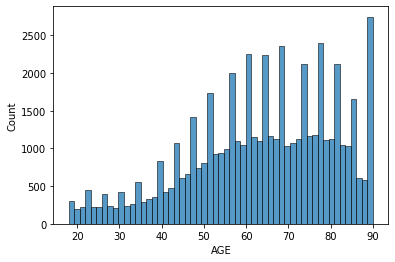

In [178]:
sns.histplot(x = 'AGE', data = df)

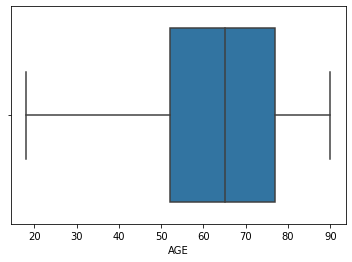

In [179]:
sns.boxplot(x = 'AGE', data = df)

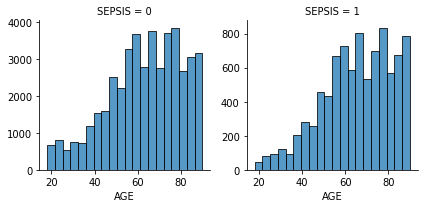

In [180]:
g = sns.FacetGrid(df, col = 'SEPSIS', sharey = False)
g.map(sns.histplot, 'AGE', bins = 20)

In [182]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS', 'ADULT',
       'DIAG_COUNT_DAY', 'CPT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS'],
      dtype='object')

In [4]:
numerical_feaures = ['LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS', 'ADULT',
       'DIAG_COUNT_DAY', 'CPT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY']

for col_name in numerical_feaures:
  sns.displot(data = df, x = col_name, hue = 'SEPSIS', stat = 'density', kde = True)
  plt.show()

NameError: ignored

# Setup

In [49]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,ETHNICITY,GENDER,DOB,LOS_ICU,DIAG_COUNT,CPT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,ADULT,DIAG_COUNT_DAY,CPT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,WHITE,M,2078-11-11,1.3848,15,7.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,1.0,3.000000,1.400000,0.600000,9.400000,0,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,9,0.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.750000,0.000000,0.250000,2.250000,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,WHITE,M,2096-08-27,3.2458,9,0.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.642857,0.000000,0.428571,3.285714,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,WHITE,M,2055-03-16,5.5894,22,10.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,3.666667,1.666667,1.166667,0.833333,0,1,0,0,0,1,0,0,0
6,51820,148131,EMERGENCY,2184-02-06 17:37:00,2184-02-08 15:23:00,NaT,0,UPPER GI BLEED,WHITE,F,2095-03-01,1.9061,7,5.0,3,4.0,0,0,0,0,0,0,0,0,64.884615,109.320000,58.480000,72.280000,18.466667,36.611111,97.769231,109.000000,88,1.906944,1.0,3.500000,2.500000,1.500000,2.000000,0,1,0,0,1,1,0,0,0


In [50]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS', 'ADULT',
       'DIAG_COUNT_DAY', 'CPT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS'],
      dtype='object')

In [51]:
features_list = ['IN_HOSP_DEATH', 'LOS_ICU', 'DIAG_COUNT', 'CPT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT',
       'SEPSIS', 'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC',
       'HEMATOLOGIC', 'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean',
       'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
       'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS',
       'DIAG_COUNT_DAY', 'CPT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'GENDER_F', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED',
       'ETHNICITY_OTHERS', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT']

len(features_list)

41

In [52]:
X = df[features_list]
y = df['SEPSIS']

# Train-test Split

* Help mitigate overfitting (model learns to fit the noise and error terms of the data) while we train machine learning models
* Allow us to report an unbiased performance metric using data unseen by the model
* A 70-30 or 80-20 split is usually the most common. 

![](https://miro.medium.com/max/694/1*tBErXYVvTw2jSUYK7thU2A.png)

([Source](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [68]:
X_train.shape

(41169, 41)

In [69]:
X_test.shape

(10293, 41)

As a result, our training and test set would include 49,981 and 12,496 admissions respectively.

# Logistic Regression

In this example, we would be utilizing the package package [Scikit-learn](https://scikit-learn.org/stable/user_guide.html) heavily for modelling. In Scikit-learn, the general flow can be simplified as follows:

1. Specify a model to be trained
  * Choose a type of model based on your task and dataset. A full list of available models in the package can be found [here](https://scikit-learn.org/stable/modules/classes.html).
  * Set the hyperparameters of the model. 
  * Assign the model to a variable.
2. Train the model
  * Call the `.fit()` function using your cleaned train dataset.
3. Make predictions
  * Call the `.predict()` function using your cleaned test dataset.

## Model Training and Prediction

In [70]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1, 
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [71]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [72]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs. 

In [73]:
model_lr.predict_proba(X_test) # the two columns represent the prob of 0 and 1 respectively 

array([[6.72384306e-01, 3.27615694e-01],
       [9.99029779e-01, 9.70220617e-04],
       [9.90600384e-01, 9.39961600e-03],
       ...,
       [9.99761181e-01, 2.38818745e-04],
       [9.62792369e-01, 3.72076309e-02],
       [4.91989791e-01, 5.08010209e-01]])

In [74]:
dfoutput = model_lr.predict_proba(X_test)

## Evaluation

There are several metrics for evaluating the binary classification performances. In general, F1-score, being the harmonic mean of precision and recall, is the most common metric for these kind of machine learning problems.  

![binary classification metrics](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

([Source](https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html))

In [75]:
accuracy_score(y_test, y_pred_lr)

0.9143106965899155

In [76]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8616
           1       0.80      0.64      0.71      1677

    accuracy                           0.91     10293
   macro avg       0.86      0.80      0.83     10293
weighted avg       0.91      0.91      0.91     10293



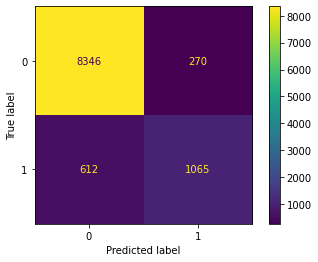

In [77]:
plot_confusion_matrix(model_lr, X_test, y_test, values_format = 'd')
plt.show()

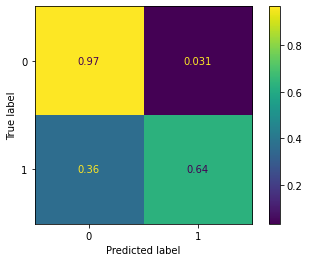

In [78]:
# recall-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'true') 
plt.show()

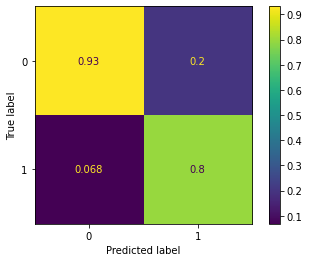

In [79]:
# precision-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'pred')
plt.show()

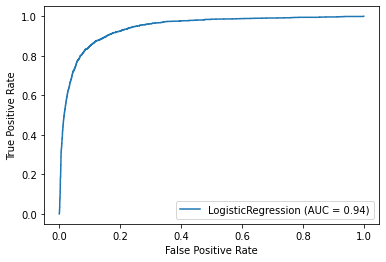

In [80]:
plot_roc_curve(model_lr, X_test, y_test)
plt.show()

**Observations**

* Despite having an accuracy of 92.6%, the overall F1-score is around 48%. The high accuracy is due to class imbalance and the model predicted the majority class (`SEPSIS == 0`) correctly. 
* The recall for the positive examples is 34%, meaning that only around one-third of those who died within their hospital stay is successfully detected by the model.

#Random Forest Model

![Random Forest](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

([Source](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/))

## Model Training and Prediction

Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees.

In [89]:
model_rf1 = RandomForestClassifier(n_estimators = 200, 
                                   random_state = 1,
                                   n_jobs = -1)

In [90]:
model_rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [91]:
y_pred_rf1 = model_rf1.predict(X_test)

## Evaluation

In [92]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8616
           1       1.00      1.00      1.00      1677

    accuracy                           1.00     10293
   macro avg       1.00      1.00      1.00     10293
weighted avg       1.00      1.00      1.00     10293



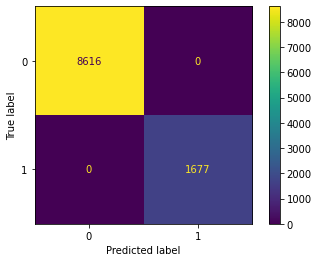

In [93]:
plot_confusion_matrix(model_rf1, X_test, y_test, values_format = 'd')
plt.show()

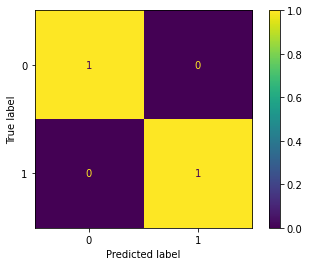

In [94]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'true') # recall
plt.show()

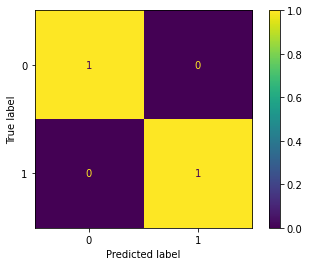

In [95]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'pred') # precision
plt.show()

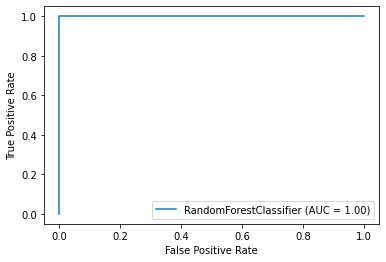

In [96]:
plot_roc_curve(model_rf1, X_test, y_test)

#Tuning Random Forest Model

Now, we try to **tune the hyperparameters** of the random forest model above based on cross-validation and grid search. We apply the `GridSearchCV()` function and specify a list of hyperparameters and their respective values to be tested. Models are trained for each combination of values and fold. The best performing set of hyperparameters across all folds would then be reported and used. 

![train-validation-test split](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

([Source](https://scikit-learn.org/stable/))

---

Performing this step requires at least a basic understanding on the meaning and effect of each hyperparameter. You should always refer to the docs of the model you are using in this step ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) in this case). An explanation of Random Forest hyperparameters can also be found [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/).

In [97]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [100, 200, 300],   # number of decision trees in the forest 
    'max_depth': [10, 40, None],       # how many times can each tree be split. None means no specific limit. 
    'class_weight': ['balanced', None] # weight of each sample. None means equal weight, balanced would put more weight on the less represented classes
}

In [98]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 1, n_jobs = -1), # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 3,                                                            # 3-fold cross-validation
    scoring = 'f1',                                                    # metric to be optimized
    n_jobs = -1, 
    verbose = 2
    )

In [99]:
grid_search_rf.fit(X_train, y_train)

# this would take 10 to 15 minutes to run
# this could take even longer depending on the number of hyperparameters to be tested, number of folds or the size of the dataset

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                     

## Tuning Results



```
# This is formatted as code
```

Retrieve the best performing set of hyperparams using `.best_params_`

In [100]:
grid_search_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

Retrieve the best performing model using .best_estimator_ and save it as a seperate variable.


In [101]:
model_rf2 = grid_search_rf.best_estimator_

In [102]:
model_rf2

# Note: this would be the same as training a seperate model using the same inputs, i.e.
# model_rf2 = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
#                                    n_jobs=-1, random_state=1)
# model_rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Use `.cv_results_` in case you want to look into the details of each set of hyperparams. This could help you determine the apprioriate range of each hyperparameter, and thus setting up better `param_grid`'s in any subsequent tuning using more refined ranges. For exampleIn the example below, it appears that having a `max_depth` of 10 is better than both 40 and `None`.

In [103]:
pd.DataFrame(grid_search_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.296800,0.127229,0.192203,0.051048,balanced,10,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",1.0,1.0,1.0,1.0,0.0,1
1,7.966098,0.084902,0.436264,0.010270,balanced,10,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",1.0,1.0,1.0,1.0,0.0,1
2,11.987856,0.027259,0.608454,0.044946,balanced,10,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",1.0,1.0,1.0,1.0,0.0,1
3,4.362056,0.058306,0.267281,0.047651,balanced,40,100,"{'class_weight': 'balanced', 'max_depth': 40, ...",1.0,1.0,1.0,1.0,0.0,1
4,8.505461,0.066232,0.476080,0.044651,balanced,40,200,"{'class_weight': 'balanced', 'max_depth': 40, ...",1.0,1.0,1.0,1.0,0.0,1
5,12.613508,0.055751,0.670317,0.044387,balanced,40,300,"{'class_weight': 'balanced', 'max_depth': 40, ...",1.0,1.0,1.0,1.0,0.0,1
6,4.489398,0.113634,0.295550,0.048616,balanced,None,100,"{'class_weight': 'balanced', 'max_depth': None...",1.0,1.0,1.0,1.0,0.0,1
7,8.458428,0.105265,0.469496,0.045147,balanced,None,200,"{'class_weight': 'balanced', 'max_depth': None...",1.0,1.0,1.0,1.0,0.0,1
8,12.755681,0.132495,0.638332,0.005557,balanced,None,300,"{'class_weight': 'balanced', 'max_depth': None...",1.0,1.0,1.0,1.0,0.0,1
9,4.177445,0.064566,0.270099,0.048953,None,10,100,"{'class_weight': None, 'max_depth': 10, 'n_est...",1.0,1.0,1.0,1.0,0.0,1


## Evaluation

In [104]:
y_pred_rf2 = model_rf2.predict(X_test)

In [105]:
print(classification_report(y_test, y_pred_rf2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8616
           1       1.00      1.00      1.00      1677

    accuracy                           1.00     10293
   macro avg       1.00      1.00      1.00     10293
weighted avg       1.00      1.00      1.00     10293



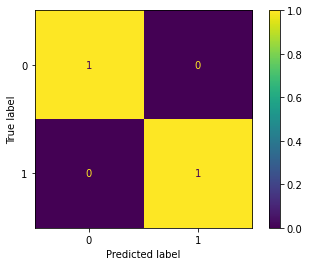

In [106]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'true') # recall
plt.show()

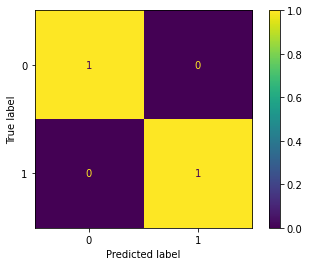

In [107]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'pred') # precision
plt.show()

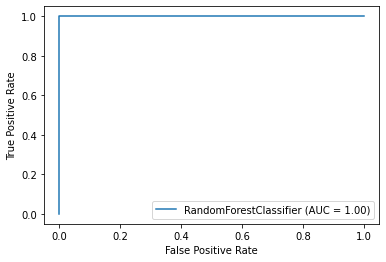

In [108]:
plot_roc_curve(model_rf2, X_test, y_test)

**Observations**

* The AUC (0.93 vs 0.92), accuracy (0.94 vs 0.9) and F1-scores (0.78 vs 0.77) of the untuned and tuned model are comparable. 
* The overall recall of the tuned model is remarkably higher (72% vs 82%). In particular, 72% of those who died within their hospital stay is successfully detected by the model.

## Understanding the model

One major strength of tree-based machine learning models is its inherent ability to report feature importance. This could be useful to finding insights in the model.

In [109]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list)
model_rf2_importance

IN_HOSP_DEATH                       0.006377
LOS_ICU                             0.010560
DIAG_COUNT                          0.031958
CPT_COUNT                           0.030663
TRANSFER_COUNT                      0.001627
MICRO_COUNT                         0.100454
SEPSIS                              0.574056
ORGAN_FAILURE                       0.019038
CARDIOVASCULAR                      0.034095
RENAL                               0.017742
HEPATIC                             0.000258
HEMATOLOGIC                         0.001519
METABOLIC                           0.000661
NEUROLOGIC                          0.000144
HeartRate_Mean                      0.004149
SysBP_Mean                          0.007412
DiasBP_Mean                         0.002943
MeanBP_Mean                         0.005275
RespRate_Mean                       0.008225
TempC_Mean                          0.002574
SpO2_Mean                           0.002296
Glucose_Mean                        0.002046
AGE       

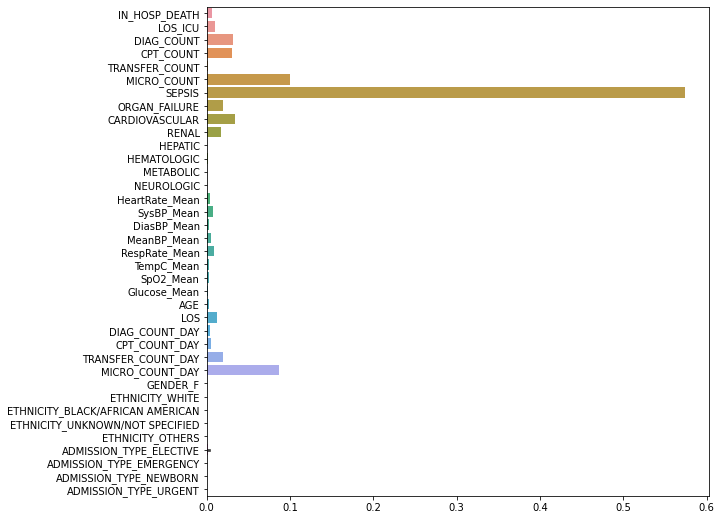

In [110]:
plt.figure(figsize = (9, 9))
sns.barplot(x = model_rf2.feature_importances_, y = features_list)

## Saving and Loading your trained model

After training a model you might want to save your model to your Google Drive so that you do not need to re-train it next time. (As a side note, due to the random nature of most machine learning algorithms, if you did not set a `random_state` while training, you would end up with a model with different trained parameters when you re-train a model)

In [111]:
import joblib

To save:

In [112]:
joblib.dump(model_rf2, gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

['/content/gdrive/MyDrive/mimic_in_hosp_mortality_model_rf2.joblib']

To load:

In [113]:
model_rf2_loaded = joblib.load(gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

In [114]:
model_rf2_loaded

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# Discussion

How well will the models above translate into a decision support system in practice? Here are some issues you may think about (which is beyond the scope of training machine learning models itself):

* What are the purposes or goals of the model? Do they align with the interests and focuses of clinicians, patients or other stakeholders? 
* Suppose we trained a reasonably reliable model. What could be the associated interventions based on the model predictions?
* What are the limitations of the model from an operational perspective? 
  * e.g. consider the time of which the variables becomes available. Could the model deliver the predictions in a timely manner? Can this be improved? 